In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Cleaning  

In [5]:
df = pd.read_csv('data/unpopular_rants_30k.csv')

In [227]:
#df has 30k observations, 15k from the 'rant' subreddit, and 15k from the 'unpopularopinions' subreddit
#need to remove rows will null in 'selftext', will need 'selftext' for modeling
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        30000 non-null  object
 1   created_utc  30000 non-null  int64 
 2   selftext     28957 non-null  object
 3   subreddit    30000 non-null  object
 4   author       30000 non-null  object
 5   media_only   30000 non-null  bool  
 6   permalink    30000 non-null  object
dtypes: bool(1), int64(1), object(5)
memory usage: 1.4+ MB


In [228]:
df.dropna(inplace=True)

In [229]:
#df is free of nulls
df.isnull().sum()

title          0
created_utc    0
selftext       0
subreddit      0
author         0
media_only     0
permalink      0
dtype: int64

In [230]:
# 28957 rows remain
df.shape

(28957, 7)

In [231]:
#need to exclude rows with '[removed]' in selftext, those posts were removed by the moderators
df.tail()

,title,created_utc,selftext,subreddit,author,media_only,permalink
29995,A battle pass system in a video game makes it ...,1615248988,[removed],unpopularopinion,SomeGuysCookie,False,/r/unpopularopinion/comments/m0u54c/a_battle_p...
29996,I hate John Greene and the Crash Course videos,1615248952,I find it a bit scary how mainstream the Crash...,unpopularopinion,thedankmister,False,/r/unpopularopinion/comments/m0u4mz/i_hate_joh...
29997,Car gasoline smells good,1615248944,[removed],unpopularopinion,TheRealistMF,False,/r/unpopularopinion/comments/m0u4jk/car_gasoli...
29998,"Best seat in a car is in the back, right behin...",1615248931,I genuinely never understood why people would ...,unpopularopinion,fatima_mdx,False,/r/unpopularopinion/comments/m0u4dt/best_seat_...
29999,Teachers are annoying and it’s not because of ...,1615248888,People hate on teachers now because they won’t...,unpopularopinion,Rrrroman,False,/r/unpopularopinion/comments/m0u3v5/teachers_a...


In [232]:
#16497 observations remain
df = df.loc[df['selftext'] != '[removed]', :]
df.shape

(16497, 7)

In [233]:
# 16023 observations remain after removing rows with '[removed]' or '[deleted]' in 'selftext'
df = df.loc[df['selftext'] != '[deleted]', :]
df.shape

(16023, 7)

In [234]:
# 53% of the posts are from 'rant', 47% are from unpop-opinions
df['subreddit'].value_counts(normalize=True)

rant                0.530799
unpopularopinion    0.469201
Name: subreddit, dtype: float64

In [235]:
df.reset_index(drop=True, inplace=True)

In [236]:
#making a column that combines the title of the post, with the selftext
df['all_text'] = df['title'] + ' ' + df['selftext']

In [237]:
#noticed a lot of '\n' in the text indicating a new line, going to replace those with empty space-text
for i in range(0 ,len(df)):
    df['all_text'][i] = df['all_text'][i].replace('\n', ' ')

<ipython-input-237-721b3fc30edf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['all_text'][i] = df['all_text'][i].replace('\n', ' ')


In [238]:
#example of an all_text entry 
df['all_text'][3333]

'Refusing to wear a mask in public during a pandemic is the same as not turning your headlights on when it\'s raining. And it sure has been raining for a long time.     I\'ve been to two gravesite burials 57 days apart from each other. We could have prevented all these needless deaths. What happened to "We\'re all in this together"?'

In [239]:
#David R. found this method to remove special characters from the text. 
df['all_text'] = df['all_text'].replace('[^\w ]','',regex=True).astype(str) 

In [240]:
#all special characters have been removed from 'all_text'
#didnt remove them from 'title' or 'selftext', in case I need those characters later
df['all_text'][0]

'policemen today I watched another video of police fucking someone up  I had a conversation with friends and I was blown away when they took the cops side and I dont know if I am in bazzarro world or what  The cops responded to a car stalled in traffic and was a middle aged black guy in the drivers seat not moving still with shoulder belt on  The cops screamed at him to get out of the car  driver still not moving  so they tased him in the head and pepper sprayed him  Guy still not moving  They open the door and drag him to the round and let his car roll over his foot  Guy still not responding  The fucking guy was having a stroke and the only reponse the cops had was to tase him and pepper spray him  Why is there an undeclared war on the public  Where are the cops that I was taught were your friends and good guys  Now we have paramilitary thugs who have the ability to maim and kill without any consequences  WHAT THE FUCK  I am mid 60s american southern male  I have worked long and hard 

# EDA % More Cleaning 

In [241]:
#idea to create word_count for each row came from lab 5.02
total_word_count = []
for i in range(0, len(df['all_text'])):
    split_words = df['all_text'][i].split(' ')
    word_count = len(split_words)
    total_word_count.append(word_count)
df['total_word_count'] = total_word_count

In [242]:
#the rant subreddit seems to have more total words per post than unpop-opinions
df.groupby('subreddit')['total_word_count'].mean()

subreddit
rant                211.968724
unpopularopinion    134.295956
Name: total_word_count, dtype: float64

In [243]:
#need to do something about these monologue posts, they will throw my model off 
df['total_word_count'].describe()

count    16023.000000
mean       175.524621
std        178.676756
min          2.000000
25%         74.000000
50%        122.000000
75%        213.500000
max       4686.000000
Name: total_word_count, dtype: float64

In [244]:
#removing total_words_counts above 1,000
df = df.loc[df['total_word_count'] <= 1000, :]

In [245]:
#removing total_word_counts less than 25 
df = df.loc[df['total_word_count'] > 25, :]

In [246]:
#15916 posts remain
df.shape

(15615, 9)

In [247]:
df['total_word_count'].describe()

count    15615.000000
mean       170.275696
std        142.180963
min         26.000000
25%         76.000000
50%        124.000000
75%        213.000000
max        993.000000
Name: total_word_count, dtype: float64

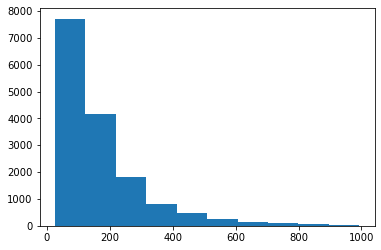

In [248]:
plt.hist(df['total_word_count']);

Most of the posts are under 200 words


In [249]:
#after removing outliers, rant still seems to have a higher average total_word_count than unpop-opinions
df.groupby('subreddit')['total_word_count'].mean()

subreddit
rant                204.153439
unpopularopinion    133.506944
Name: total_word_count, dtype: float64

In [250]:
#rant has a higher stand.dev for total_word_count than unpop-opinions
df.groupby('subreddit')['total_word_count'].std()

subreddit
rant                164.350548
unpopularopinion    101.215228
Name: total_word_count, dtype: float64

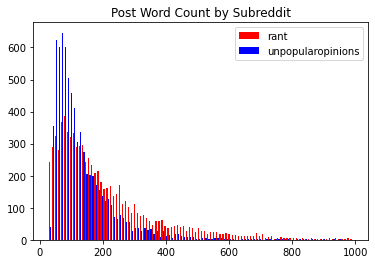

In [251]:
rant_count = df.loc[df['subreddit'] == 'rant', 'total_word_count']
pins_count = df.loc[df['subreddit'] == 'unpopularopinion', 'total_word_count']

plt.hist([rant_count, pins_count], color=['r', 'b'], bins=100)
plt.legend(labels=['rant', 'unpopularopinions'])
plt.title('Post Word Count by Subreddit');

The rant histogram is smoother and has a higher word count on average, while the unpopular-opinion histgram is very steep and drops off quickly as the word count increases.  

In [252]:
df.head()

,title,created_utc,selftext,subreddit,author,media_only,permalink,all_text,total_word_count
0,policemen?,1617068544,today I watched another video of police fuckin...,rant,redyrytnow,False,/r/rant/comments/mg4z9o/policemen/,policemen today I watched another video of pol...,268
1,To my GF fuck off I dont care if you are disab...,1617066705,I'm autistic yes but I AM NOT FUCKING DISABLED...,rant,the-ugly-potato,False,/r/rant/comments/mg4fj4/to_my_gf_fuck_off_i_do...,To my GF fuck off I dont care if you are disab...,139
2,"It should be acceptable to write ""it's"" instea...",1617065894,People whine and whine about how some people w...,rant,nam3pbrc,False,/r/rant/comments/mg46l6/it_should_be_acceptabl...,It should be acceptable to write its instead o...,229
3,Twitter is the absolute worst!,1617065669,"I got suspended just now and I don’t know why,...",rant,Snoo-84344,False,/r/rant/comments/mg448x/twitter_is_the_absolut...,Twitter is the absolute worst I got suspended ...,45
4,Is it too hard to have a single fuckiing beer ...,1617064702,"Hi ranters,\n\nI was always trying to be hones...",rant,13Mark17,False,/r/rant/comments/mg3ty9/is_it_too_hard_to_have...,Is it too hard to have a single fuckiing beer ...,339


In [253]:
df.to_csv('data/clean_opinion_rants.csv', index=False)

# Lemmatizing & Stemming 

In [258]:
df.reset_index(inplace=True)

In [259]:
lemmatizer = WordNetLemmatizer()

In [260]:
p_stemmer = PorterStemmer()

In [261]:
#created this function to stem/lemmatize all of the words in the 'all_text' column and return a list of 
# strings of each 'all_text' post stemmed/lammatized
def base_words(df, method):
    if method == 'stem':
        stems = []
        for i in range(len(df['all_text'])):
            final = ''
            text = [word for word in df['all_text'][i].split(' ') if word != '']
            stemmed = [p_stemmer.stem(word) for word in text]
            for stem in stemmed:
                final += stem + ' '
            stems.append(final)
        return stems
    if method == 'lemm':
        lemms = []
        for i in range(len(df['all_text'])):
            final = ''
            text = [word for word in df['all_text'][i].split(' ') if word != '']
            lemmed = [lemmatizer.lemmatize(word) for word in text]
            for lem in lemmed:
                final += lem + ' '
            lemms.append(final)
        return lemms
    else:
        return 'Method not found!'

In [262]:
lem_words = base_words(df, 'lemm')

In [263]:
stem_words = base_words(df, 'stem')

In [264]:
lem_words[4444]

'Dating in High School On Reddit in movie on tv people always talk about guy trying hard to get girl in high school Dude I went to a HS where girl were DESPERATE for guy and played sub to get them Also guy were seriously dating for PERSONALITY Was I in bizarro land '

In [265]:
stem_words[4444]

'date in high school On reddit in movi on tv peopl alway talk about guy tri hard to get girl in high school dude I went to a HS where girl were desper for guy and play sub to get them also guy were serious date for person wa I in bizarro land '

In [266]:
#adding columns for the stemmed and lemmatized words
df['stem'] = stem_words
df['lem'] = lem_words

In [ ]:
df.to_csv('data/stemlem.csv', index=False)

# Sentiment Analysis 

In [267]:
sentiment = SentimentIntensityAnalyzer()

In [268]:
#this function will return a list containing each posts overall sentiment
def get_sentiments(sentences):
    sentiments = []
    for post in sentences:
        sent = sentiment.polarity_scores(post)['compound']
        sentiments.append(sent)
    return sentiments

In [303]:
rts = df.loc[df['subreddit'] == 'rant', ['lem', 'total_word_count']]
ops = df.loc[df['subreddit'] == 'unpopularopinion', ['lem', 'total_word_count']]

In [304]:
rant_sentiments = get_sentiments(rts['lem'])
opinion_sentiments = get_sentiments(ops['lem'])

In [309]:
rts['sent'] = rant_sentiments
ops['sent'] = opinion_sentiments

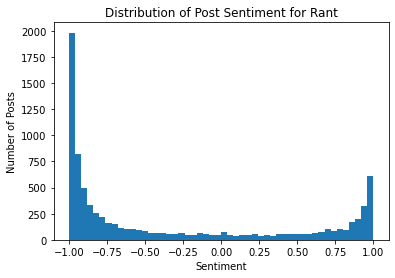

In [391]:
plt.hist(rts['sent'], bins=50)
plt.title('Distribution of Post Sentiment for Rant')
plt.xlabel('Sentiment')
plt.ylabel('Number of Posts');

The distribution shows that most posts are either very positive or very negative, which makes sense when talking about someone ranting. Most of the rants are negative. 

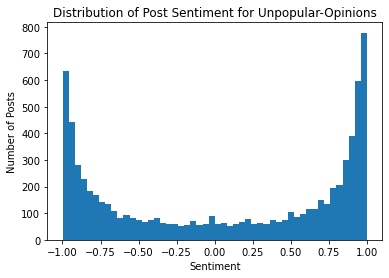

In [392]:
plt.hist(ops['sent'], bins=50)
plt.title('Distribution of Post Sentiment for Unpopular-Opinions')
plt.xlabel('Sentiment')
plt.ylabel('Number of Posts');

This distribution is more evenly spread out, more of a balance between positive and negative posts than the rant posts. But the same trend as above holds true for unpop-opinions, most posts are either very positve or very negative.  

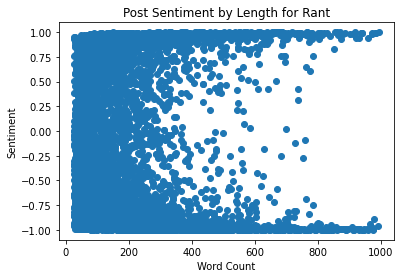

In [319]:
plt.scatter(rts['total_word_count'], rts['sent'])
plt.title('Post Sentiment by Length for Rant')
plt.xlabel('Word Count')
plt.ylabel('Sentiment');

This plot shows that as word count increases, sentiment gravitates towards either 1 or -1. The longer the rant, the more "enthusiasm" the posts has 

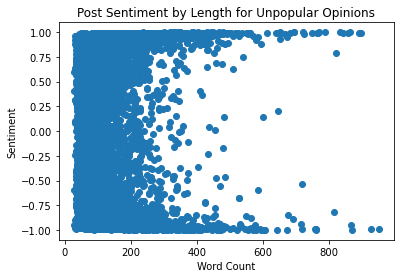

In [322]:
plt.scatter(ops['total_word_count'], ops['sent'])
plt.title('Post Sentiment by Length for Unpopular Opinions')
plt.xlabel('Word Count')
plt.ylabel('Sentiment');

A similar yet less severe trend is seen for unpopular-opinions. As the post length increases, the sentiment of the post gravitates towards either 1 or -1 

# Count Vectorizor Analysis 

In [373]:
X_rant = df.loc[df['subreddit'] == 'rant', 'lem']
X_ops = df.loc[df['subreddit'] == 'unpopularopinion', 'lem']

In [374]:
r_cvec = CountVectorizer(stop_words='english')
op_cvec = CountVectorizer(stop_words='english')

In [383]:
r_cvec.fit(X_rant)
X_rant = r_cvec.transform(X_rant)

op_cvec.fit(X_ops)
X_ops = op_cvec.transform(X_ops)

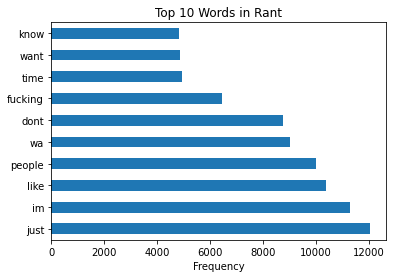

In [406]:
X_rant_df = pd.DataFrame(X_rant.todense(), columns=r_cvec.get_feature_names())
X_rant_df.sum().sort_values(ascending=False).head(10).plot(kind='barh')
plt.title('Top 10 Words in Rant')
plt.xlabel('Frequency');

The f-word jumps off the screen. It makes sense that it is 7th most frequent work in the rant subreddit, when people are ranting about something, they are usually angry (sentiment distribution), and those types of words are more likely to be used. 

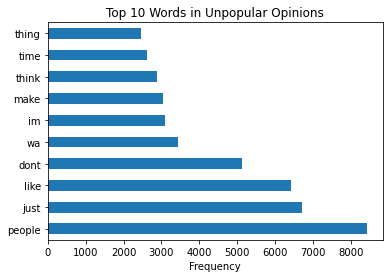

In [407]:
X_ops_df = pd.DataFrame(X_ops.todense(), columns=op_cvec.get_feature_names())
X_ops_df.sum().sort_values(ascending=False).head(10).plot(kind='barh')
plt.title('Top 10 Words in Unpopular Opinions')
plt.xlabel('Frequency');

The unpopular-opininions subreddit has 7 of the common words seen in rant. The 3 other words are: thing, make and think. It also makes sense these 3 words are unqiue to unpopular-opinions as these words are used when stating an opinion. 

In [394]:
df['subreddit'].value_counts(normalize=True)

rant                0.520461
unpopularopinion    0.479539
Name: subreddit, dtype: float64